#Hohmann Transfer LEO to GEO
This module is setup in the following way for each code box:
- 1. Hohmann transfer with statc mass
- 2. Non-static mass, with required input
- 3. Starship orbit transfer (no plot)
- 4. Starship orbit transfer (with plot)
- 5.  Starship orbit transfer (with plot of full ellipse)

# Hohmann Transfer Orbit: Equations and Explanation

---

### 1. Circular Orbital Velocity

The orbital speed for a circular orbit at radius \( r \) around Earth is:

$$
v = \sqrt{\frac{\mu}{r}}
$$

where:  
- \( v \) = orbital velocity (m/s)  
- \( \mu = GM \) = standard gravitational parameter for Earth \((3.986 \times 10^{14} \, m^3/s^2)\)  
- \( r \) = distance from Earth's center (m)

---

### 2. Hohmann Transfer Orbit

A Hohmann transfer moves a spacecraft between two circular orbits of radii \( r_1 \) and \( r_2 \) by transferring along an elliptical orbit with semi-major axis:

$$
a_t = \frac{r_1 + r_2}{2}
$$

---

### 3. Speeds at Key Points of the Transfer Orbit

- Velocity in the initial circular orbit (e.g., LEO):

$$
v_1 = \sqrt{\frac{\mu}{r_1}}
$$

- Velocity in the final circular orbit (e.g., GEO):

$$
v_2 = \sqrt{\frac{\mu}{r_2}}
$$

- Velocity at perigee (closest point) of transfer ellipse:

$$
v_{t1} = \sqrt{2\frac{\mu}{r_1} - \frac{\mu}{a_t}}
$$

- Velocity at apogee (farthest point) of transfer ellipse:

$$
v_{t2} = \sqrt{2\frac{\mu}{r_2} - \frac{\mu}{a_t}}
$$

---

### 4. Required Velocity Changes (Delta-V)

The spacecraft performs two burns:

- Burn 1: to enter the transfer ellipse at perigee

$$
\Delta v_1 = v_{t1} - v_1
$$

- Burn 2: to circularize at the apogee of transfer ellipse

$$
\Delta v_2 = v_2 - v_{t2}
$$

The **total delta-v** is the sum:

$$
\Delta v_{\text{total}} = \Delta v_1 + \Delta v_2
$$

---

### 5. Transfer Time (Half Orbital Period of Ellipse)

Time to complete the transfer (half of the elliptical orbit) is:

$$
T = \pi \sqrt{\frac{a_t^3}{\mu}}
$$

where:  
- \( T \) is time in seconds

---

### Summary

Using these equations, we can calculate the **speeds**, **velocity changes**, and **transfer duration** needed to move a satellite from LEO to GEO using the Hohmann transfer maneuver.


### Equations of Motion (Integral Form)

Given Newton's second law with gravitational acceleration:

$$
\frac{d^2 \vec{r}}{dt^2} = -\frac{\mu}{r^3} \vec{r}
$$

We integrate twice to get:

**Velocity:**

$$
\vec{v}(t) = \vec{v}_0 - \int_{t_0}^{t} \frac{\mu \, \vec{r}(\tau)}{r(\tau)^3} \, d\tau
$$

**Position:**

$$
\vec{r}(t) = \vec{r}_0 + \int_{t_0}^{t} \vec{v}(\tau) \, d\tau
$$


Initial LEO radius: 6871.0 km
Target GEO radius: 42157.0 km
Circular velocity LEO: 7.617 km/s
Circular velocity GEO: 3.075 km/s
Delta-v 1 (boost to transfer orbit): 2371.63 m/s
Delta-v 2 (circularize at GEO): 1446.99 m/s
Total delta-v: 3818.61 m/s
Transfer time (half orbit): 5.31 hours


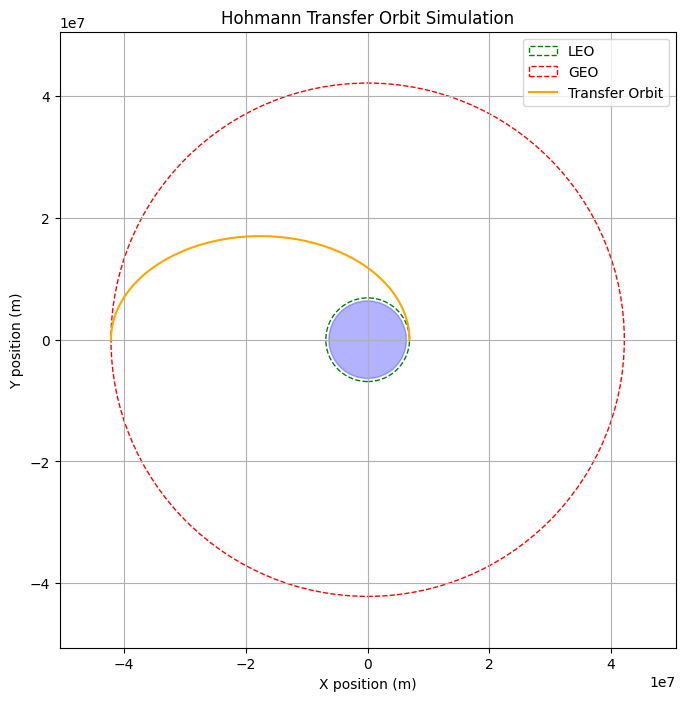

In [7]:
'''
For simplicity, this calculates and plots the trajectory for a fixed mass
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
MU_EARTH = 3.986004418e14  # Earth's gravitational parameter, m^3/s^2
R_EARTH = 6371e3  # Earth's radius in meters

def orbital_elements(r, v):
    """Calculate orbital elements from position r and velocity v vectors."""
    r_norm = np.linalg.norm(r)
    v_norm = np.linalg.norm(v)
    h = np.cross(r, v)  # specific angular momentum (scalar since 2D)
    energy = v_norm**2 / 2 - MU_EARTH / r_norm
    a = -MU_EARTH / (2 * energy)  # semi-major axis
    e = np.sqrt(1 - h**2 / (MU_EARTH * a))
    return a, e

def gravity(t, state):
    """ODE for two-body problem in 2D."""
    x, y, vx, vy = state
    r = np.array([x, y])
    r_norm = np.linalg.norm(r)
    ax, ay = -MU_EARTH * r / r_norm**3
    return [vx, vy, ax, ay]

def runge_kutta_step(f, t, y, dt):
    """Single Runge-Kutta 4 step (not used since using solve_ivp)"""
    k1 = np.array(f(t, y))
    k2 = np.array(f(t + dt/2, y + dt/2 * k1))
    k3 = np.array(f(t + dt/2, y + dt/2 * k2))
    k4 = np.array(f(t + dt, y + dt * k3))
    return y + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

def velocity_for_circular_orbit(r):
    """Calculate circular orbit velocity magnitude at radius r."""
    return np.sqrt(MU_EARTH / r)

def delta_v_hohmann(r1, r2):
    """Calculate total delta-v for Hohmann transfer from r1 to r2."""
    # At each time step of the transfer it is in elliptical orbit
    v1 = velocity_for_circular_orbit(r1)
    v2 = velocity_for_circular_orbit(r2)
    a_transfer = (r1 + r2) / 2
    v_transfer_perigee = np.sqrt(2 * MU_EARTH / r1 - MU_EARTH / a_transfer) # vis-visa eqn. for elliptical v
    v_transfer_apogee = np.sqrt(2 * MU_EARTH / r2 - MU_EARTH / a_transfer)

    # the two burns
    delta_v1 = abs(v_transfer_perigee - v1)
    delta_v2 = abs(v2 - v_transfer_apogee)
    total_delta_v = delta_v1 + delta_v2
    return delta_v1, delta_v2, total_delta_v

def propagate_orbit(r0, v0, t_span, steps=1000):
    """Numerically integrate orbit given initial position, velocity and time span."""
    state0 = [r0[0], r0[1], v0[0], v0[1]]
    t_eval = np.linspace(t_span[0], t_span[1], steps)
    sol = solve_ivp(gravity, t_span, state0, t_eval=t_eval, rtol=1e-9)
    return sol.t, sol.y[:2].T  # times and positions (x, y)

def plot_orbits(r_leo, r_geo, r_transfer, transfer_pos):
    fig, ax = plt.subplots(figsize=(8,8))

    # Earth
    earth = plt.Circle((0,0), R_EARTH, color='b', alpha=0.3)
    ax.add_artist(earth)

    # Plot circular orbits
    circle1 = plt.Circle((0,0), r_leo, color='g', fill=False, linestyle='--', label='LEO')
    circle2 = plt.Circle((0,0), r_geo, color='r', fill=False, linestyle='--', label='GEO')
    ax.add_artist(circle1)
    ax.add_artist(circle2)

    # Plot transfer orbit
    ax.plot(transfer_pos[:,0], transfer_pos[:,1], color='orange', label='Transfer Orbit')

    # Formatting plot
    ax.set_xlim(-r_geo*1.2, r_geo*1.2)
    ax.set_ylim(-r_geo*1.2, r_geo*1.2)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X position (m)')
    ax.set_ylabel('Y position (m)')
    ax.set_title('Hohmann Transfer Orbit Simulation')
    ax.legend()
    plt.grid(True)
    plt.show()

def main():
    # Radii of orbits (circular)
    r_leo = R_EARTH + 500e3    # 500 km altitude
    r_geo = R_EARTH + 35786e3  # Geostationary orbit altitude

    print(f"Initial LEO radius: {r_leo/1000:.1f} km")
    print(f"Target GEO radius: {r_geo/1000:.1f} km")

    # Calculate circular velocities
    v_leo = velocity_for_circular_orbit(r_leo)
    v_geo = velocity_for_circular_orbit(r_geo)

    print(f"Circular velocity LEO: {v_leo/1000:.3f} km/s")
    print(f"Circular velocity GEO: {v_geo/1000:.3f} km/s")

    # Calculate delta-v required for Hohmann transfer
    dv1, dv2, total_dv = delta_v_hohmann(r_leo, r_geo)
    print(f"Delta-v 1 (boost to transfer orbit): {dv1:.2f} m/s")
    print(f"Delta-v 2 (circularize at GEO): {dv2:.2f} m/s")
    print(f"Total delta-v: {total_dv:.2f} m/s")

    # Initial position and velocity in LEO (starting on x-axis, velocity in y direction)
    r0 = np.array([r_leo, 0])
    v0 = np.array([0, v_leo + dv1])  # After first burn (boost to transfer orbit)

    # Time of half transfer orbit (half period)
    a_transfer = (r_leo + r_geo) / 2
    T_transfer = np.pi * np.sqrt(a_transfer**3 / MU_EARTH)  # seconds

    print(f"Transfer time (half orbit): {T_transfer/3600:.2f} hours")

    # Propagate transfer orbit
    t_span = (0, T_transfer)
    t, pos = propagate_orbit(r0, v0, t_span)

    # Plot orbits and transfer
    plot_orbits(r_leo, r_geo, a_transfer, pos)

if __name__ == "__main__":
    main()


Initial LEO radius: 6871.0 km
Target GEO radius: 42157.0 km
Circular velocity LEO: 7.617 km/s
Circular velocity GEO: 3.075 km/s
Delta-v 1 (boost to transfer orbit): 2371.63 m/s
Delta-v 2 (circularize at GEO): 1446.99 m/s
Total delta-v: 3818.61 m/s
Enter rocket dry mass (kg): 120000
Enter initial fuel mass (kg): 1200000
Enter engine specific impulse Isp (seconds): 380
Fuel consumed for burn 1: 621475.89 kg
Mass after burn 1: 698524.11 kg
Fuel consumed for burn 2: 224775.90 kg
Mass after burn 2: 473748.20 kg
Total fuel consumed: 846251.80 kg
Remaining fuel: 353748.20 kg
Transfer time (half orbit): 5.31 hours


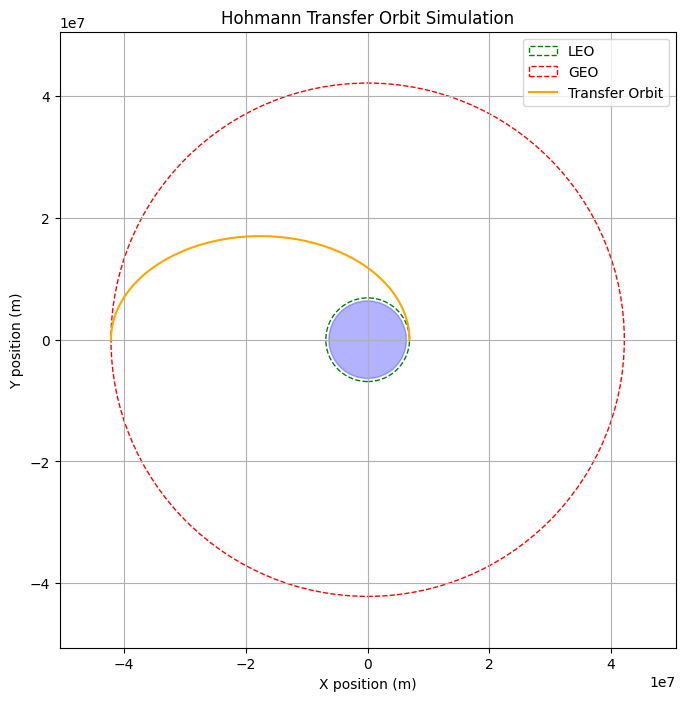

In [8]:
'''
Now we take into consider mass and propellant using the rocket equation. Each
burn is considered instantaneous.
'''

def rocket_fuel_mass(delta_v, I_sp, m0):
    """Calculate fuel mass needed for given delta-v using rocket equation."""
    g0 = 9.80665  # m/s^2
    v_e = I_sp * g0
    mf = m0 / np.exp(delta_v / v_e)
    fuel_used = m0 - mf
    return fuel_used, mf

def main():
    # Radii of orbits (circular)
    r_leo = R_EARTH + 500e3    # 500 km altitude
    r_geo = R_EARTH + 35786e3  # Geostationary orbit altitude

    print(f"Initial LEO radius: {r_leo/1000:.1f} km")
    print(f"Target GEO radius: {r_geo/1000:.1f} km")

    # Calculate circular velocities
    v_leo = velocity_for_circular_orbit(r_leo)
    v_geo = velocity_for_circular_orbit(r_geo)

    print(f"Circular velocity LEO: {v_leo/1000:.3f} km/s")
    print(f"Circular velocity GEO: {v_geo/1000:.3f} km/s")

    # Calculate delta-v required for Hohmann transfer
    dv1, dv2, total_dv = delta_v_hohmann(r_leo, r_geo)
    print(f"Delta-v 1 (boost to transfer orbit): {dv1:.2f} m/s")
    print(f"Delta-v 2 (circularize at GEO): {dv2:.2f} m/s")
    print(f"Total delta-v: {total_dv:.2f} m/s")

    # Get rocket parameters from user
    dry_mass = float(input("Enter rocket dry mass (kg): "))
    fuel_mass = float(input("Enter initial fuel mass (kg): "))
    I_sp = float(input("Enter engine specific impulse Isp (seconds): "))

    m0 = dry_mass + fuel_mass  # initial total mass

    # Calculate fuel consumption for first burn
    fuel_used1, m_after_burn1 = rocket_fuel_mass(dv1, I_sp, m0)
    print(f"Fuel consumed for burn 1: {fuel_used1:.2f} kg")
    print(f"Mass after burn 1: {m_after_burn1:.2f} kg")

    # Calculate fuel consumption for second burn
    fuel_used2, m_after_burn2 = rocket_fuel_mass(dv2, I_sp, m_after_burn1)
    print(f"Fuel consumed for burn 2: {fuel_used2:.2f} kg")
    print(f"Mass after burn 2: {m_after_burn2:.2f} kg")

    total_fuel_used = fuel_used1 + fuel_used2
    print(f"Total fuel consumed: {total_fuel_used:.2f} kg")
    print(f"Remaining fuel: {fuel_mass - total_fuel_used:.2f} kg")

    # Initial position and velocity in LEO (starting on x-axis, velocity in y direction)
    r0 = np.array([r_leo, 0])
    v0 = np.array([0, v_leo + dv1])  # After first burn (boost to transfer orbit)

    # Time of half transfer orbit (half period)
    a_transfer = (r_leo + r_geo) / 2
    T_transfer = np.pi * np.sqrt(a_transfer**3 / MU_EARTH)  # seconds

    print(f"Transfer time (half orbit): {T_transfer/3600:.2f} hours")

    # Propagate transfer orbit
    t_span = (0, T_transfer)
    t, pos = propagate_orbit(r0, v0, t_span)

    # Plot orbits and transfer
    plot_orbits(r_leo, r_geo, a_transfer, pos)

if __name__ == "__main__":
    main()

# Hohmann Transfer with Rocket Equation: Starship Example

---

### 1. Circular Orbital Velocity (same as before)

The orbital speed for a circular orbit at radius \( r \):

$$
v = \sqrt{\frac{\mu}{r}}
$$

where:  
- \( \mu \) is Earth's gravitational parameter  
- \( r \) is orbit radius

---

### 2. Hohmann Transfer Orbit (same as before)

Semi-major axis of the elliptical transfer orbit:

$$
a_t = \frac{r_1 + r_2}{2}
$$

---

### 3. Speeds at Key Points on the Transfer Ellipse (same as before)

- Initial circular orbit speed:

$$
v_1 = \sqrt{\frac{\mu}{r_1}}
$$

- Final circular orbit speed:

$$
v_2 = \sqrt{\frac{\mu}{r_2}}
$$

- Transfer orbit speed at perigee:

$$
v_{t1} = \sqrt{2\frac{\mu}{r_1} - \frac{\mu}{a_t}}
$$

- Transfer orbit speed at apogee:

$$
v_{t2} = \sqrt{2\frac{\mu}{r_2} - \frac{\mu}{a_t}}
$$

---

### 4. Delta-V Required for Burns (same as before)

- Burn 1 to enter transfer orbit:

$$
\Delta v_1 = v_{t1} - v_1
$$

- Burn 2 to circularize at GEO:

$$
\Delta v_2 = v_2 - v_{t2}
$$

Total delta-v:

$$
\Delta v_{total} = \Delta v_1 + \Delta v_2
$$

---

### 5. Transfer Time (same as before)

Time for half orbit transfer:

$$
T = \pi \sqrt{\frac{a_t^3}{\mu}}
$$

---

### 6. **Rocket Equation** (new in this version!)

To estimate **propellant mass** required for each burn, we use the rocket equation:

$$
\Delta v = I_{sp} \cdot g_0 \cdot \ln \left(\frac{m_0}{m_f}\right)
$$

Rearranged to find fuel mass:

$$
m_f = \frac{m_0}{e^{\Delta v / (I_{sp} \cdot g_0)}}
$$

$$
m_{\text{fuel used}} = m_0 - m_f
$$

where:  
- \( I_{sp} \) is the specific impulse of the engine (seconds)  
- \( g_0 \) is standard gravity \(9.81 \, m/s^2\)  
- \( m_0 \) is the initial mass before the burn (kg)  
- \( m_f \) is the final mass after the burn (kg)

---

### 7. **Mass Model Specific to Starship**

- \( m_0 \) for the first burn includes Starship’s **dry mass + full propellant load**  
- The booster mass (Super Heavy) is **not included** in orbital transfer calculations (assumed dropped before orbit)  
- After each burn, \( m_f \) becomes the new starting mass for the next burn  
- This lets us track how much propellant is consumed and remaining mass after each burn

---

### Summary:

Compared to the basic Hohmann transfer model, this version **adds fuel mass calculation via the rocket equation** using Starship’s:

- Dry mass  
- Propellant load  
- Vacuum specific impulse  

This allows us to **assess if Starship can perform the transfer burns with its available fuel** and track how much mass remains after each burn — important for mission planning and feasibility.

---



In [3]:
import numpy as np

# Constants
MU_EARTH = 3.986004418e14  # m^3/s^2
R_EARTH = 6371e3           # meters
G0 = 9.81                  # m/s^2 standard gravity

# Starship + Super Heavy parameters (approximate)
mass_starship_dry = 120_000       # kg, dry mass of Starship (empty)
mass_starship_fuel = 1_200_000    # kg, full propellant load (Starship only)
mass_super_heavy = 3_300_000      # kg, mass of Super Heavy booster (not in orbit)
mass_starship_wet = mass_starship_dry + mass_starship_fuel  # full mass at orbit start

Isp_vac = 380     # s, vacuum specific impulse (approx Starship Raptor Vacuum)
Isp_sl  = 330     # s, sea-level Isp (for booster stage, not used here)

# Orbital radii (meters)
r_leo = R_EARTH + 500e3
r_geo = R_EARTH + 35786e3

def velocity_for_circular_orbit(r):
    return np.sqrt(MU_EARTH / r)

def delta_v_hohmann(r1, r2):
    a_transfer = (r1 + r2) / 2
    v1 = velocity_for_circular_orbit(r1)
    v2 = velocity_for_circular_orbit(r2)
    v_transfer_perigee = np.sqrt(2 * MU_EARTH / r1 - MU_EARTH / a_transfer)
    v_transfer_apogee = np.sqrt(2 * MU_EARTH / r2 - MU_EARTH / a_transfer)
    dv1 = abs(v_transfer_perigee - v1)
    dv2 = abs(v2 - v_transfer_apogee)
    return dv1, dv2, dv1 + dv2, a_transfer

def transfer_time(a_transfer):
    return np.pi * np.sqrt(a_transfer**3 / MU_EARTH)

def rocket_equation(delta_v, Isp, m_initial):
    """Calculate propellant mass needed for delta_v using rocket equation.

    m_initial = initial mass before burn (kg)
    Returns (propellant mass needed, final mass after burn)
    """
    m_final = m_initial / np.exp(delta_v / (Isp * G0))
    prop_mass = m_initial - m_final
    return prop_mass, m_final

def main():
    print("=== Orbital Parameters ===")
    print(f"LEO radius: {r_leo/1000:.1f} km")
    print(f"GEO radius: {r_geo/1000:.1f} km\n")

    # Calculate delta-v for Hohmann transfer
    dv1, dv2, total_dv, a_transfer = delta_v_hohmann(r_leo, r_geo)
    print(f"Delta-v for transfer burn 1 (LEO → transfer orbit): {dv1:.1f} m/s")
    print(f"Delta-v for transfer burn 2 (transfer orbit → GEO): {dv2:.1f} m/s")
    print(f"Total delta-v required: {total_dv:.1f} m/s\n")

    T = transfer_time(a_transfer)
    print(f"Transfer time (half elliptical orbit): {T/3600:.2f} hours\n")

    # Assume Starship is in LEO ready to do burn 1
    m0 = mass_starship_wet  # initial mass before burn 1

    # Burn 1 propellant calculation
    prop1, m1 = rocket_equation(dv1, Isp_vac, m0)
    print(f"Propellant mass for burn 1: {prop1/1000:.1f} metric tons")
    print(f"Mass after burn 1: {m1/1000:.1f} metric tons\n")

    # Burn 2 propellant calculation, starting from mass after burn 1
    prop2, m2 = rocket_equation(dv2, Isp_vac, m1)
    print(f"Propellant mass for burn 2: {prop2/1000:.1f} metric tons")
    print(f"Mass after burn 2 (final dry mass): {m2/1000:.1f} metric tons\n")

    print(f"Total propellant used: {(prop1+prop2)/1000:.1f} metric tons")
    print(f"Remaining mass fraction: {m2/m0:.3f}")

    if (prop1 + prop2) > mass_starship_fuel:
        print("\nWARNING: Required propellant exceeds full Starship fuel load!")
    else:
        print("\nStarship has enough propellant for the transfer burns.")

if __name__ == "__main__":
    main()


=== Orbital Parameters ===
LEO radius: 6871.0 km
GEO radius: 42157.0 km

Delta-v for transfer burn 1 (LEO → transfer orbit): 2371.6 m/s
Delta-v for transfer burn 2 (transfer orbit → GEO): 1447.0 m/s
Total delta-v required: 3818.6 m/s

Transfer time (half elliptical orbit): 5.31 hours

Propellant mass for burn 1: 621.3 metric tons
Mass after burn 1: 698.7 metric tons

Propellant mass for burn 2: 224.8 metric tons
Mass after burn 2 (final dry mass): 473.9 metric tons

Total propellant used: 846.1 metric tons
Remaining mass fraction: 0.359

Starship has enough propellant for the transfer burns.


=== Orbital Parameters ===
LEO radius: 6871.0 km
GEO radius: 42157.0 km

Delta-v for transfer burn 1 (LEO → transfer orbit): 2371.6 m/s
Delta-v for transfer burn 2 (transfer orbit → GEO): 1447.0 m/s
Total delta-v required: 3818.6 m/s

Transfer time (half elliptical orbit): 5.31 hours

Propellant mass for burn 1: 621.3 metric tons
Mass after burn 1: 698.7 metric tons

Propellant mass for burn 2: 224.8 metric tons
Mass after burn 2 (final dry mass): 473.9 metric tons

Total propellant used: 846.1 metric tons
Remaining mass fraction: 0.359

Starship has enough propellant for the transfer burns.


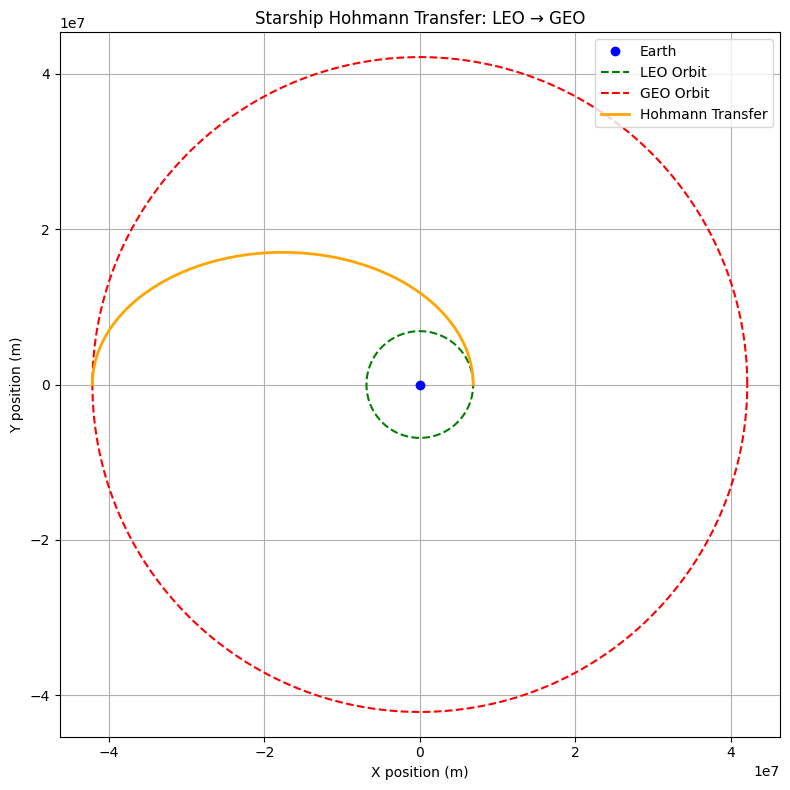

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_starship_transfer(r_leo, r_geo, a_transfer):
    theta_circ = np.linspace(0, 2 * np.pi, 500)  # For full circular orbits
    theta_transfer = np.linspace(0, np.pi, 250)  # Only half ellipse (transfer arc)

    # Circular LEO and GEO
    x_leo = r_leo * np.cos(theta_circ)
    y_leo = r_leo * np.sin(theta_circ)
    x_geo = r_geo * np.cos(theta_circ)
    y_geo = r_geo * np.sin(theta_circ)

    # Transfer ellipse (centered at Earth, focus at origin)
    e_transfer = (r_geo - r_leo) / (r_geo + r_leo)
    b_transfer = a_transfer * np.sqrt(1 - e_transfer**2)

    x_transfer = a_transfer * np.cos(theta_transfer) - a_transfer * e_transfer
    y_transfer = b_transfer * np.sin(theta_transfer)

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.plot(0, 0, 'bo', label='Earth')
    plt.plot(x_leo, y_leo, 'g--', label='LEO Orbit')
    plt.plot(x_geo, y_geo, 'r--', label='GEO Orbit')
    plt.plot(x_transfer, y_transfer, color='orange', linewidth=2, label='Hohmann Transfer')

    # Formatting
    plt.axis('equal')
    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')
    plt.title('Starship Hohmann Transfer: LEO → GEO')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    print("=== Orbital Parameters ===")
    print(f"LEO radius: {r_leo/1000:.1f} km")
    print(f"GEO radius: {r_geo/1000:.1f} km\n")

    # Calculate delta-v for Hohmann transfer
    dv1, dv2, total_dv, a_transfer = delta_v_hohmann(r_leo, r_geo)
    print(f"Delta-v for transfer burn 1 (LEO → transfer orbit): {dv1:.1f} m/s")
    print(f"Delta-v for transfer burn 2 (transfer orbit → GEO): {dv2:.1f} m/s")
    print(f"Total delta-v required: {total_dv:.1f} m/s\n")

    T = transfer_time(a_transfer)
    print(f"Transfer time (half elliptical orbit): {T/3600:.2f} hours\n")

    # Assume Starship is in LEO ready to do burn 1
    m0 = mass_starship_wet  # initial mass before burn 1

    # Burn 1 propellant calculation
    prop1, m1 = rocket_equation(dv1, Isp_vac, m0)
    print(f"Propellant mass for burn 1: {prop1/1000:.1f} metric tons")
    print(f"Mass after burn 1: {m1/1000:.1f} metric tons\n")

    # Burn 2 propellant calculation, starting from mass after burn 1
    prop2, m2 = rocket_equation(dv2, Isp_vac, m1)
    print(f"Propellant mass for burn 2: {prop2/1000:.1f} metric tons")
    print(f"Mass after burn 2 (final dry mass): {m2/1000:.1f} metric tons\n")

    print(f"Total propellant used: {(prop1+prop2)/1000:.1f} metric tons")
    print(f"Remaining mass fraction: {m2/m0:.3f}")

    if (prop1 + prop2) > mass_starship_fuel:
        print("\nWARNING: Required propellant exceeds full Starship fuel load!")
    else:
        print("\nStarship has enough propellant for the transfer burns.")

    # Now call the plot function here
    plot_starship_transfer(r_leo, r_geo, a_transfer)

if __name__ == "__main__":
    main()


=== Orbital Parameters ===
LEO radius: 6871.0 km
GEO radius: 42157.0 km

Delta-v for transfer burn 1 (LEO → transfer orbit): 2371.6 m/s
Delta-v for transfer burn 2 (transfer orbit → GEO): 1447.0 m/s
Total delta-v required: 3818.6 m/s

Transfer time (half elliptical orbit): 5.31 hours

Propellant mass for burn 1: 621.3 metric tons
Mass after burn 1: 698.7 metric tons

Propellant mass for burn 2: 224.8 metric tons
Mass after burn 2 (final dry mass): 473.9 metric tons

Total propellant used: 846.1 metric tons
Remaining mass fraction: 0.359

Starship has enough propellant for the transfer burns.


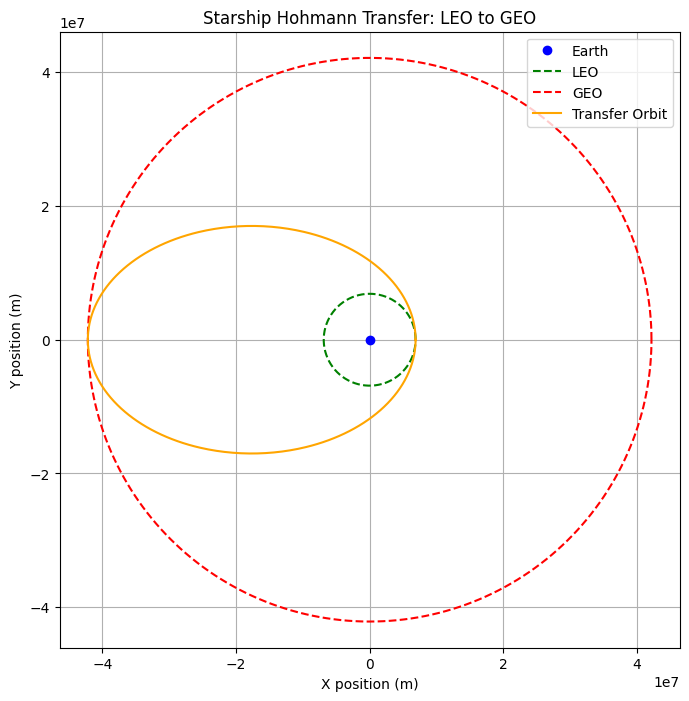

In [5]:
def plot_starship_transfer(r_leo, r_geo, a_transfer):
    theta = np.linspace(0, 2 * np.pi, 500)

    # Circular orbits
    x_leo = r_leo * np.cos(theta)
    y_leo = r_leo * np.sin(theta)
    x_geo = r_geo * np.cos(theta)
    y_geo = r_geo * np.sin(theta)

    # Elliptical transfer orbit (from perigee to apogee)
    e_transfer = (r_geo - r_leo) / (r_geo + r_leo)
    b_transfer = a_transfer * np.sqrt(1 - e_transfer**2)
    x_transfer = a_transfer * np.cos(theta) - a_transfer * e_transfer  # centered at Earth
    y_transfer = b_transfer * np.sin(theta)

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.plot(0, 0, 'bo', label='Earth')
    plt.plot(x_leo, y_leo, 'g--', label='LEO')
    plt.plot(x_geo, y_geo, 'r--', label='GEO')
    plt.plot(x_transfer, y_transfer, 'orange', label='Transfer Orbit')

    plt.axis('equal')
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.title("Starship Hohmann Transfer: LEO to GEO")
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    print("=== Orbital Parameters ===")
    print(f"LEO radius: {r_leo/1000:.1f} km")
    print(f"GEO radius: {r_geo/1000:.1f} km\n")

    # Calculate delta-v for Hohmann transfer
    dv1, dv2, total_dv, a_transfer = delta_v_hohmann(r_leo, r_geo)
    print(f"Delta-v for transfer burn 1 (LEO → transfer orbit): {dv1:.1f} m/s")
    print(f"Delta-v for transfer burn 2 (transfer orbit → GEO): {dv2:.1f} m/s")
    print(f"Total delta-v required: {total_dv:.1f} m/s\n")

    T = transfer_time(a_transfer)
    print(f"Transfer time (half elliptical orbit): {T/3600:.2f} hours\n")

    # Assume Starship is in LEO ready to do burn 1
    m0 = mass_starship_wet  # initial mass before burn 1

    # Burn 1 propellant calculation
    prop1, m1 = rocket_equation(dv1, Isp_vac, m0)
    print(f"Propellant mass for burn 1: {prop1/1000:.1f} metric tons")
    print(f"Mass after burn 1: {m1/1000:.1f} metric tons\n")

    # Burn 2 propellant calculation, starting from mass after burn 1
    prop2, m2 = rocket_equation(dv2, Isp_vac, m1)
    print(f"Propellant mass for burn 2: {prop2/1000:.1f} metric tons")
    print(f"Mass after burn 2 (final dry mass): {m2/1000:.1f} metric tons\n")

    print(f"Total propellant used: {(prop1+prop2)/1000:.1f} metric tons")
    print(f"Remaining mass fraction: {m2/m0:.3f}")

    if (prop1 + prop2) > mass_starship_fuel:
        print("\nWARNING: Required propellant exceeds full Starship fuel load!")
    else:
        print("\nStarship has enough propellant for the transfer burns.")

    # Now call the plot function here
    plot_starship_transfer(r_leo, r_geo, a_transfer)

if __name__ == "__main__":
    main()
